In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib.pyplot as plt

import src.datamaker as datamaker
import src.training as training
import src.models as models

from tqdm import tqdm

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
def data_generator(filename, batch_size, start_idx=0, end_idx=None):
    if os.path.isfile(filename):
        with np.load(filename, allow_pickle=True, mmap_mode='r') as data:
            X_train = data['X_train']
            y_train = data['y_train']

            n_tasks = y_train.shape[0]  # Number of tasks

            # If end_idx is not specified, set it to the number of tasks
            if end_idx is None:
                end_idx = n_tasks

            # Loop over the specified range in batches
            for idx in range(start_idx, end_idx, batch_size):
                batch_end_idx = min(idx + batch_size, end_idx)
                X_batch = X_train[idx:batch_end_idx]
                y_batch = y_train[idx:batch_end_idx]
                
                # Take logarithm of spectra in y_batch
                Y_batch_log = np.log(y_batch)

                yield X_batch, Y_batch_log
    else:
        raise FileNotFoundError(f'Data file {filename} not found.')

In [3]:
class CNN(nn.Module):
    def __init__(self, input_size=10, latent_dim=(16, 16), output_dim=750, dropout_rate=0.3):
        super(CNN, self).__init__()
        # Fully connected layers to map the input parameters to a 2D latent space
        self.fc1 = nn.Linear(input_size, latent_dim[0] * latent_dim[1])  # Mapping to 2D latent space
        # Reshape the output to be 2D: (batch_size, 1, latent_dim[0], latent_dim[1])
        self.latent_dim = latent_dim
        # Convolutional layers with dilations and dropout
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=4, dilation=4)
        # Dropout layer after each convolutional layer
        self.dropout = nn.Dropout(dropout_rate)
        # Calculating the output size of the convolutional layers
        conv_output_dim = latent_dim[0]  # Keep output dimensions same due to padding
        self.fc2_input_size = 64 * conv_output_dim * conv_output_dim  # 64 channels from conv3
        self.fc2 = nn.Linear(self.fc2_input_size, output_dim)  # Output size is 750

    def forward(self, x):
        # Step 1: Map input parameters to 2D latent space
        x = F.relu(self.fc1(x))
        x = x.view(-1, 1, self.latent_dim[0], self.latent_dim[1])  # Reshape to 2D latent space
        # Step 2: Pass through convolutional layers with dropout
        x = F.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout after conv1
        x = F.relu(self.conv2(x))
        x = self.dropout(x)  # Apply dropout after conv2
        x = F.relu(self.conv3(x))
        x = self.dropout(x)  # Apply dropout after conv3
        # Step 3: Flatten and fully connected layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_features)
        # Step 4: Fully connected output layer
        x = self.fc2(x)
        return x

In [15]:
reload(training)

# Test CNN model
model = CNN(
    input_size=10,
    latent_dim=(16, 16),
    output_dim=750,
    dropout_rate=0.2
)
np.random.seed(14)

# Initialise MAML model
CosyMAML_log = training.Adam_MAML(
            model=model,
            loss_fn=nn.MSELoss(),
            inner_lr=0.001,
            outer_lr=0.01,
            inner_decay=0,
            outer_decay=0,
            seed=14,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-8,
            device='cuda'
        )

filename = 'data/200tasks_2000samples.npz'
n_tasks = 200  # Number of tasks in the dataset

# Example usage of the data generator
batch_size = 10  # Number of tasks per batch
train_gen = data_generator(filename, batch_size)

# Load data in batches using the generator
i = 0
loss = []
outer_epochs = 100
for _ in range(outer_epochs):
    for X_train_batch, Y_train_log_batch in train_gen:

        print(f'Loaded batch with shape: {X_train_batch.shape}, {Y_train_log_batch.shape}')
        # Now you can train on each batch

        # if i == 0:
        #     # Randomly shuffle tasks
        #     tasks = np.arange(len(X_train_batch))
        #     tasks = np.random.permutation(tasks)
        #     # Split tasks into training and cross-validation
        #     cv_tasks = tasks[:5]
        #     train_tasks = np.delete(tasks, cv_tasks)
        #     # Split data into training and cross-validation
        #     X_cross_val = X_train_batch[cv_tasks]
        #     Y_cross_val = Y_train_log_batch[cv_tasks]
        #     X_train_batch = X_train_batch[train_tasks]
        #     Y_train_log_batch = Y_train_log_batch[train_tasks]

        # Meta-train model
        meta_loss = CosyMAML_log.meta_train(
            x_train=X_train_batch,
            y_train=Y_train_log_batch,
            spt_frac=0.6,
            outer_epochs=1,
            inner_epochs=5,
            rec_loss=True,
            plot_prog=False,
            plot_summary=False
        );

        loss.extend(meta_loss)

        i += 1

Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.74it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.76it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.78it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.78it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.78it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.75it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.75it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.76it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 12.75it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.11it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.01it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.02it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.04it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.02it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.03it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.01it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.02it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.02it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.02it/s]


Loaded batch with shape: (10, 2000, 10), (10, 2000, 750)


10it [00:00, 11.03it/s]


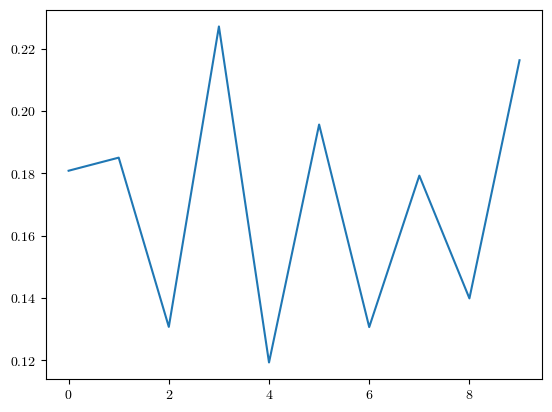

In [14]:
plt.plot(meta_loss)

Text(0, 0.5, 'Loss')

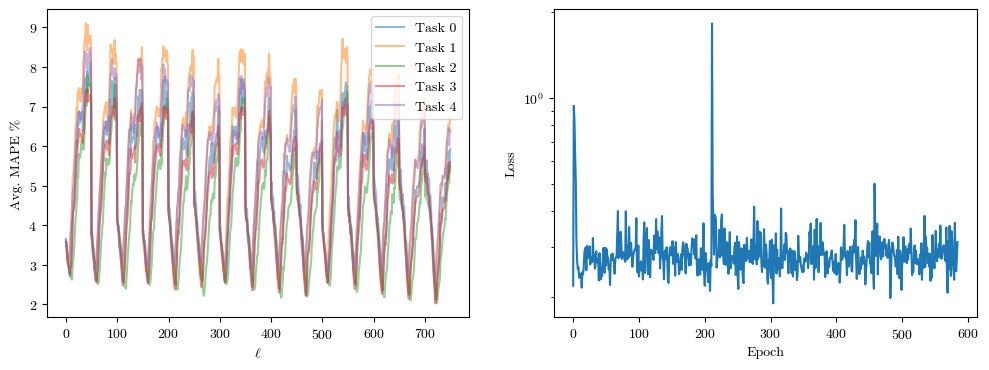

In [7]:
# Cross-validate model
err_all, err_avg_all, y_pred, y_true, rand_inds = CosyMAML_log.cross_validate(
    x_val=X_cross_val,
    y_val=Y_cross_val,
    n_shots=512,
    adapt_steps=256
)
# Plot cross-validation results
_, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(X_cross_val.shape[0]):
    axs[0].plot(err_avg_all[i], ls='-', alpha=0.5, label='Task %d' % i)
axs[0].legend()
axs[0].set_ylabel('Avg. MAPE %')
axs[0].set_xlabel(r'$\ell$')

# plot loss
axs[1].plot(loss, label='Loss')
axs[1].set_yscale('log')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

In [1]:
# Plot only samples from worst task with < 5% max error
task = 2

plt.figure()
good = 0
for i, err in enumerate(err_all[task]):
    if np.max(err) < 5:
        if i % 100 == 0:
            plt.plot(err, ls='-', alpha=0.4)
        good += 1
plt.ylabel('MAPE %')
plt.xlabel(r'$\ell$')
plt.title('Task %d, %d good samples' % (task, good))
print('Failure rate: %.2f' % (1- good/len(err_all[task])))

NameError: name 'plt' is not defined

Correlation coefficient of average error: 0.62
Correlation coefficient of max error: 0.64


Text(0, 0.5, 'MAPE %')

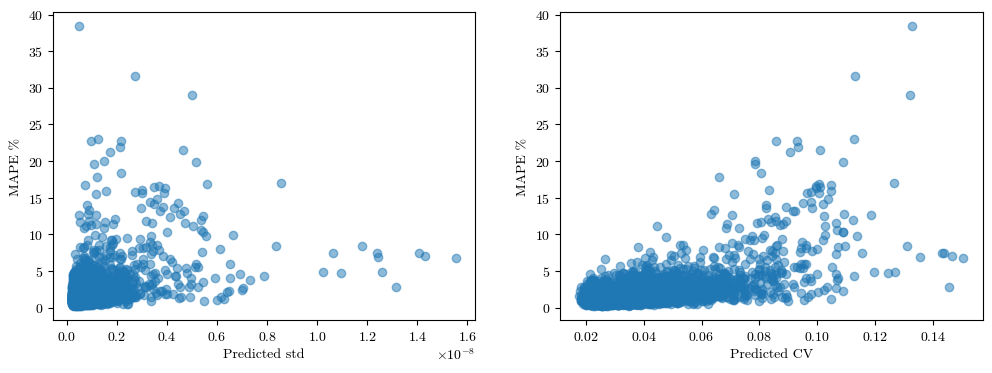

In [8]:
# Compute various summary stats from predictions
y_pred_task = y_pred[task]

# Compute mean and standard deviation of predictions
y_pred_mean = np.mean(y_pred_task, axis=0)
y_pred_std = np.std(y_pred_task, axis=0)

# average across scales
y_pred_mean = np.mean(y_pred_mean, axis=1)
y_pred_std = np.mean(y_pred_std, axis=1)
err_avg_sample = np.mean(err_all[task], axis=1)
err_max_sample = np.max(err_all[task], axis=1)

# Compute coefficient of variation
y_pred_cv = y_pred_std / y_pred_mean

# compute correlation cofficient of err and coefficient of variation
corr_avg = np.corrcoef(y_pred_cv, err_avg_sample)
corr_max = np.corrcoef(y_pred_cv, err_max_sample)
print('Correlation coefficient of average error: %.2f' % corr_avg[0, 1])
print('Correlation coefficient of max error: %.2f' % corr_max[0, 1])

# Plot std vs err
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(y_pred_std, err_avg_sample, alpha=0.5)
axs[0].set_xlabel('Predicted std')
axs[0].set_ylabel('MAPE %')

# Plot cv vs err
axs[1].scatter(y_pred_cv, err_avg_sample, alpha=0.5)
axs[1].set_xlabel('Predicted CV')
axs[1].set_ylabel('MAPE %')

- Estimator might be biased
- MSE can be decomposed in both bias and variance
- Might be better to use cross-validation with bounds on accuracy as a function of calls to CCL

- Cross validation has very well understood mathematical properties, so can be used to get theoretical bounds on emulation error
- Try using 10 fold cross-validation
- Cross-validate specific regions of parameter space and use that to decide whether to use preidctions based on how close they fall
- Can also try train an auxilliary emulator to predict the uncertainty once I have cross-val errors
- ## Fundamental requirement is to understand error as a function input space

Total samples: 1488
Samples with error > 5: 246
Samples with error <= 5: 1242


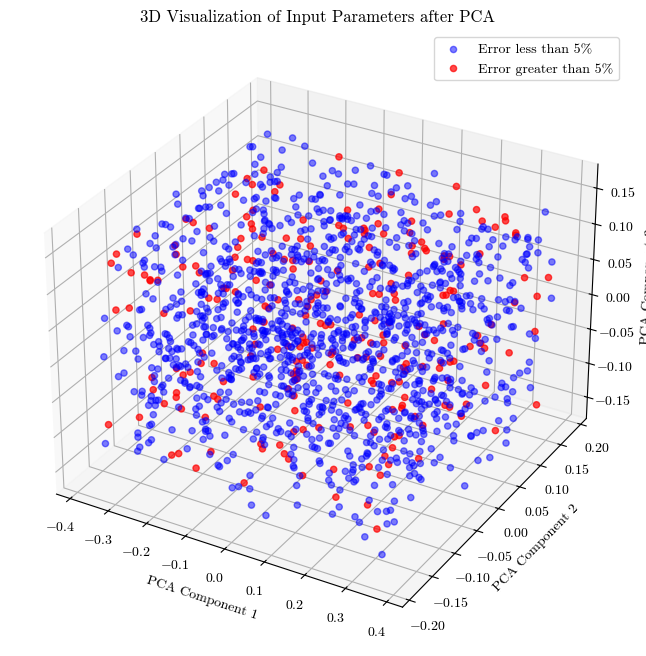

Explained variance by PCA components: [0.68382744 0.1517129  0.10621175]
Total explained variance by the first two components: 0.9417520848314122


In [74]:
from sklearn.decomposition import PCA

test_inds = np.arange(len(X_cross_val[0]))
test_inds = np.delete(test_inds, rand_inds)

# Step 2: Identify samples where error exceeds 5
error_threshold = 5
high_error_indices = np.where(err_max_sample > error_threshold)[0]
low_error_indices = np.where(err_max_sample <= error_threshold)[0]

print(f"Total samples: {len(err_max_sample)}")
print(f"Samples with error > {error_threshold}: {len(high_error_indices)}")
print(f"Samples with error <= {error_threshold}: {len(low_error_indices)}")

# Step 3: Apply dimensionality reduction to the input parameters

# Option A: Using PCA to reduce to 2D
pca = PCA(n_components=3)
inputs_pca = pca.fit_transform(X_cross_val[task, test_inds, :])

# Visualization function
def plot_3d_scatter(reduced_inputs, method_name):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot low-error samples
    ax.scatter(
        reduced_inputs[low_error_indices, 0],
        reduced_inputs[low_error_indices, 1],
        reduced_inputs[low_error_indices, 2],
        c='blue',
        alpha=0.5,
        label=f'Error less than {error_threshold}%'
    )

    # Plot high-error samples
    ax.scatter(
        reduced_inputs[high_error_indices, 0],
        reduced_inputs[high_error_indices, 1],
        reduced_inputs[high_error_indices, 2],
        c='red',
        alpha=0.7,
        label=f'Error greater than {error_threshold}%'
    )

    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.set_zlabel(f'{method_name} Component 3')
    ax.set_title(f'3D Visualization of Input Parameters after {method_name}')
    ax.legend()
    plt.show()

plot_3d_scatter(inputs_pca, 'PCA')

# Optional: Print explained variance ratio to understand how much information is retained
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")
print(f"Total explained variance by the first two components: {explained_variance.sum()}")


In [ ]:
# Implement cross validation code
train_gen = data_generator(filename, batch_size)

def KfoldCrossVal(n_folds, n_tasks, maml):

    batch_size = n_tasks // n_folds

    # Load data in batches using the generator
    i = 0
    for X_train_batch, Y_train_log_batch in train_gen:
        